## Applying Text Pre-processing techniques and BERT Modeling to Classify ServiceNow Tickets

In [ ]:
!pip install numpy transformers torch accelerate datasets



In [ ]:
random_state = 138 # Set a seed for reproducibility

### Exploratory Data Analysis

In [ ]:
from datasets import load_dataset, Dataset

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('incident_fix.csv', encoding = 'cp1252')

In [ ]:
data = df[['short_description','cmdb_ci']]
data = data.groupby('cmdb_ci').filter(lambda x: (x['short_description'].count()>500).any())

In [ ]:
data.tail(20)

,short_description,cmdb_ci
49844,AMIE compliance,SoM Compliance
49845,[ONSITE - CS - FMS] Reimage laptop - Latitude...,Contract Desktop Support
49848,Zoom App in Outlook is not working,SoM Desktop Support
49849,Wants to check to make sure device has all upd...,SoM Desktop Support
49850,Issue with calls not getting recorded in Verint,Phone Services
49851,AMIE - Device is out of compliance Lenovo (801...,SoM Compliance
49853,Computer not connecting to some stanford websi...,SoE Desktop Support
49854,*Re-Activate DUO,Two-Step Authentication (DUO)
49856,Repeated certificate prompts for Firefox,Cardinal Key
49858,SUNet ID is currently inactive please active r...,SUNet ID Services


<BarContainer object of 18 artists>

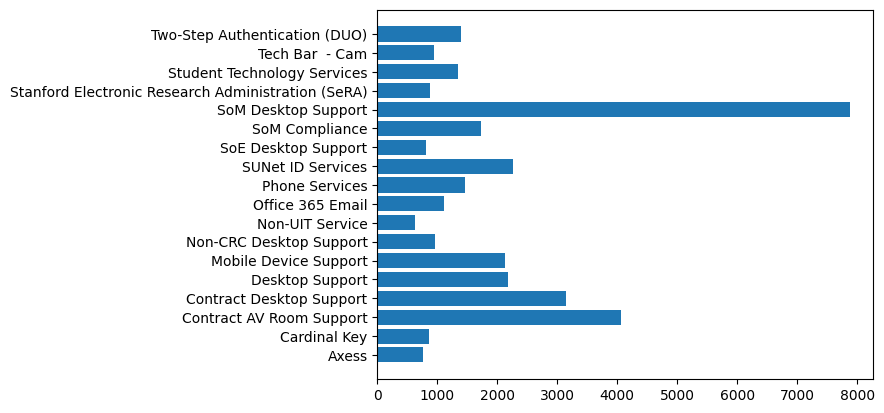

In [ ]:
plot = data.groupby('cmdb_ci').count()
plt.barh(plot.index, plot['short_description'].values)

In [ ]:
data = df[['short_description','cmdb_ci']]
data = data.groupby('cmdb_ci').filter(lambda x: (x['short_description'].count()>400).any())


<BarContainer object of 22 artists>

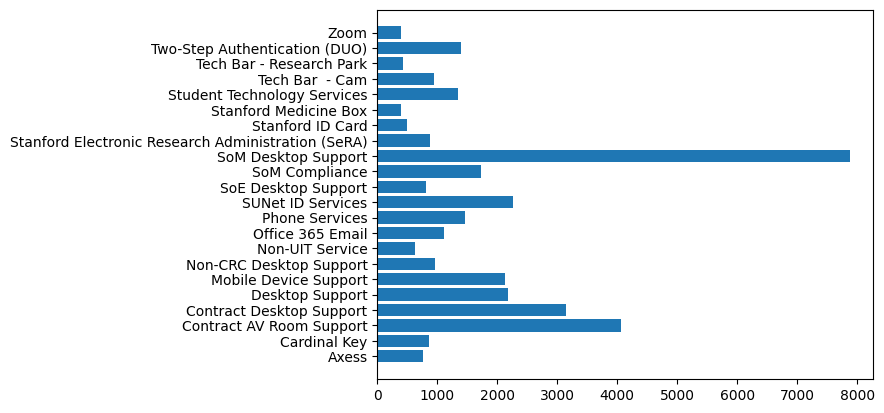

In [ ]:
plot = data.groupby('cmdb_ci').count()
plt.barh(plot.index, plot['short_description'].values)

### Cleaning and pre-processing text data

In [ ]:
data = data[pd.notnull(data.cmdb_ci)]
data = data[pd.notnull(data.short_description)]

In [ ]:
len(data)

36270

In [ ]:
# Remove extra spaces
import re
data["short_description"] = data["short_description"].apply(lambda text: re.sub(' +', ' ', text))

In [ ]:
data['short_description'].values

array(['Not able to login to lane library',
       "Trouble getting into W2 on Axess - pdf tab doesn't launch",
       'SHC after hours', ...,
       '[de-stanfordize] POD MBA sn: C02DR23YQ6L7 - left Stanford; still getting Stanford alerts on my computer / CCSR',
       'IT Device Enrollment',
       "Can't fil out google form to apply for TA positions"],
      dtype=object)

### Tokenize dataset and pull pretrained model from Transformers, and initialize Trainer/TrainingArguments

In [ ]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
# Initialize training/tokenizer parameters
model_name = "roberta-base" # For using bert, specify bert-base-uncased
num_labels = data['cmdb_ci'].nunique()
# batch_size = 8
metric_name = "eval_f1"
device = "cuda"

In [ ]:
from sklearn.preprocessing import LabelEncoder

data['cmdb_ci'] = LabelEncoder().fit_transform(data.cmdb_ci)

In [ ]:
train_df, rest_df = train_test_split(data, random_state = random_state, train_size = 0.7)

In [ ]:
valid_df, test_df = train_test_split(rest_df, random_state = random_state, train_size = 0.66)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [ ]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["short_description"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels

  encoding["labels"] = examples['cmdb_ci']

  return encoding

In [ ]:
encoded_dataset_train = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
encoded_dataset_valid = valid_dataset.map(preprocess_data, batched=True, remove_columns=valid_dataset.column_names)
encoded_dataset_test = test_dataset.map(preprocess_data, batched=True, remove_columns=test_dataset.column_names)


Map:   0%|          | 0/25389 [00:00<?, ? examples/s]

Map:   0%|          | 0/7181 [00:00<?, ? examples/s]

Map:   0%|          | 0/3700 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from transformers import EvalPrediction

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_class_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = torch.argmax(probs, dim=1)
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'eval_f1': f1_micro_average,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_class_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

### Perform grid search for tuning learning rate, batch size. Train RoBERTa model

In [ ]:
batch_sizes = [16]#, 32]
learning_rates = [2e-5]#, 3e-5, 1e-5]
num_epochs = 4

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    print("Performing training for {2} model on parameters: Batch Size: {0}, Learning Rate: {1}".format(batch_size, learning_rate, model_name))
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    model.to(device)

    args = TrainingArguments(
        f"bert-finetuned-sem_eval-english",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
        #push_to_hub=True,
    )

    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_dataset_train,
        eval_dataset=encoded_dataset_valid,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    print("Saving Model!")
    trainer.save_model("28_july_roberta/{2}_{0}_{1}".format(batch_size, learning_rate, model_name))



Performing training for roberta-base model on parameters: Batch Size: 16, Learning Rate: 2e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.050500,1.000417,0.712436,0.712436
2,0.879600,0.916891,0.732210,0.732210
3,0.724000,0.898314,0.744325,0.744325
4,0.648100,0.894806,0.747389,0.747389


Saving Model!


### Load and evaluate model on test set

In [ ]:
checkpoint = "28_july_roberta/roberta-base_16_2e-05"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

In [ ]:
trainer = Trainer(
        model,
        args,
        train_dataset=encoded_dataset_train,
        eval_dataset=encoded_dataset_valid,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

In [ ]:
trainer.evaluate(encoded_dataset_test)

{'eval_f1': 0.7391891891891891,
 'eval_loss': 0.924587070941925,
 'eval_accuracy': 0.7391891891891892,
 'eval_runtime': 10.0206,
 'eval_samples_per_second': 369.239,
 'eval_steps_per_second': 23.152}